* [1] A. Panakkat, and H. Adeli, “Neural network models for earthquake magnitude prediction using multiple seismicity indicators,” International Journal of Neural Systems, vol. 17(1), pp. 13–33, 2007.
*   [2] F. Martínez-Álvarez, A. Morales-Esteban, and J. Reyes, “Neural networks to predict earthquakes in Chile,” Applied Soft Computing, vol. 13, pp. 1314-1328, 2013.



In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Normalization, Embedding, Flatten, Bidirectional, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
base_dir = "../input/earthquakes-dataset/benchmark-earthquake-dataset"
indicators_adeli = "Adeli and Panakkat seismicity indicators"
indicators_reyes = "Reyes et al. seismicity indicators"

aggregation = "1_week" # 1_week, 2_weeks or 1_month

In [ ]:
def list_files(base_dir, indicators, aggregation):
    file_names = os.listdir(os.path.join(base_dir, indicators))
    return [os.path.join(base_dir, indicators, f) for f in file_names if aggregation in f]

adeli_files = list_files(base_dir, indicators_adeli, aggregation)
reyes_files = list_files(base_dir, indicators_reyes, aggregation)

In [ ]:
adeli_files

['../input/earthquakes-dataset/benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/chile_AP_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/japan_AP_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/hindukush_AP_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/california_AP_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Adeli and Panakkat seismicity indicators/sicily_AP_1_week.csv']

In [ ]:
reyes_files

['../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/sicily_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/hindukush_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/california_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/japan_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/chile_Reyes_1_week.csv']

In [ ]:
reyes_files = [reyes_files[4], reyes_files[3], reyes_files[1], reyes_files[2], reyes_files[0]]

In [ ]:
reyes_files

['../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/chile_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/japan_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/hindukush_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/california_Reyes_1_week.csv',
 '../input/earthquakes-dataset/benchmark-earthquake-dataset/Reyes et al. seismicity indicators/sicily_Reyes_1_week.csv']

In [ ]:
regions = ['chile', 'japan', 'hindukush', 'california', 'sicily']

In [ ]:
def get_and_join_data(adeli_filename, reyes_filename):
    df1 = pd.read_csv(adeli_filename, sep='\t', index_col='time')
    df2 = pd.read_csv(reyes_filename, sep='\t', index_col='time')
    diff = len(df2) - len(df1)
    print(diff)
    df2 = df2[diff:]
    assert(np.all(df1['mag'] == df2['mag']))
    df1 = df1.drop('mag', axis=1)
    df = pd.concat([df1, df2], ignore_index=False, axis=1)
    return df

In [ ]:
df_chile = get_and_join_data(adeli_files[0], reyes_files[0]) 
df_japan = get_and_join_data(adeli_files[1], reyes_files[1]) 
df_hindukush = get_and_join_data(adeli_files[2], reyes_files[2]) 
# df_california = get_and_join_data(adeli_files[3], reyes_files[3]) 
df_sicily = get_and_join_data(adeli_files[4], reyes_files[4]) 

139
28
35
7


## Dealing data in California

In [ ]:
df1 = pd.read_csv(adeli_files[3], sep='\t', index_col='time')
df2 = pd.read_csv(reyes_files[3], sep='\t', index_col='time')

In [ ]:
df1

,b-value,Mean square deviation,Magnitude deficit,Elapsed days,Mean magnitude,Rate of square root of energy released,Mean time between characteristic events,Coefficient of variation from mean time,mag
time,,,,,,,,,
1968-04-14,0.736419,0.017954,1.025778,102.0,3.4464,1.095776e+09,2.728091,0.290733,6.60
1968-04-21,0.737095,0.016767,1.008849,86.0,3.4627,1.313765e+09,2.650701,0.288897,4.48
1968-04-28,0.732741,0.014642,0.966446,30.0,3.4924,3.854960e+09,0.956659,0.321965,4.17
1968-05-05,0.995703,0.001548,0.170176,19.0,3.4423,2.296132e+09,0.633434,0.471628,3.69
1968-05-12,1.017334,0.002759,0.225343,24.0,3.4237,1.748404e+09,1.151226,0.482849,3.99
...,...,...,...,...,...,...,...,...,...
2018-12-02,0.952044,0.003612,0.191129,345.0,3.4399,1.329275e+08,13.208515,0.966317,4.00
2018-12-09,0.950045,0.002590,0.173975,339.0,3.4537,1.382204e+08,12.558159,0.941896,4.20
2018-12-16,0.943848,0.001931,0.153278,328.0,3.4640,1.456109e+08,12.563646,0.942498,0.00


In [ ]:
df2

,x_1i,x_2i,x_3i,x_4i,x_5i,x_6i,x_7i,mag
time,,,,,,,,
1968-04-14,-0.026083,-0.026083,-0.026083,-0.026083,-0.026083,3.420000,0.003248,6.60
1968-04-21,0.042859,0.008343,0.035234,0.005371,0.119576,3.501111,0.000208,4.48
1968-04-28,-0.055604,0.034651,-0.028860,0.061652,0.034158,3.438462,0.000249,4.17
1968-05-05,0.007476,-0.061945,0.065647,-0.060858,-0.110795,3.387273,0.000316,3.69
1968-05-12,0.023803,-0.026365,0.013331,-0.001257,-0.086471,3.395000,0.000292,3.99
...,...,...,...,...,...,...,...,...
2018-12-02,0.017870,-0.101257,0.074965,0.084456,0.043482,3.666000,0.000796,4.00
2018-12-09,-0.025828,-0.069269,-0.005429,0.075171,0.084513,3.955000,0.001087,4.20
2018-12-16,-0.064293,-0.025828,-0.069269,-0.005429,0.075171,3.620000,0.001695,0.00


In [ ]:
set(df2.axes[0]) - set(df1.axes[0])

{'1992-07-05'}

In [ ]:
df1.loc['1992-07-05'] = df1.loc['1992-06-28']
df1 = df1.sort_index()  # sorting by index
df1.loc['1992-07-05']['mag'] = df2.loc['1992-07-05']['mag']
all(df1['mag'] == df2['mag'])

True

In [ ]:
df1 = df1.drop('mag', axis=1)
df_california = pd.concat([df1, df2], ignore_index=False, axis=1)
df_california

,b-value,Mean square deviation,Magnitude deficit,Elapsed days,Mean magnitude,Rate of square root of energy released,Mean time between characteristic events,Coefficient of variation from mean time,x_1i,x_2i,x_3i,x_4i,x_5i,x_6i,x_7i,mag
time,,,,,,,,,,,,,,,,
1968-04-14,0.736419,0.017954,1.025778,102.0,3.4464,1.095776e+09,2.728091,0.290733,-0.026083,-0.026083,-0.026083,-0.026083,-0.026083,3.420000,0.003248,6.60
1968-04-21,0.737095,0.016767,1.008849,86.0,3.4627,1.313765e+09,2.650701,0.288897,0.042859,0.008343,0.035234,0.005371,0.119576,3.501111,0.000208,4.48
1968-04-28,0.732741,0.014642,0.966446,30.0,3.4924,3.854960e+09,0.956659,0.321965,-0.055604,0.034651,-0.028860,0.061652,0.034158,3.438462,0.000249,4.17
1968-05-05,0.995703,0.001548,0.170176,19.0,3.4423,2.296132e+09,0.633434,0.471628,0.007476,-0.061945,0.065647,-0.060858,-0.110795,3.387273,0.000316,3.69
1968-05-12,1.017334,0.002759,0.225343,24.0,3.4237,1.748404e+09,1.151226,0.482849,0.023803,-0.026365,0.013331,-0.001257,-0.086471,3.395000,0.000292,3.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-02,0.952044,0.003612,0.191129,345.0,3.4399,1.329275e+08,13.208515,0.966317,0.017870,-0.101257,0.074965,0.084456,0.043482,3.666000,0.000796,4.00
2018-12-09,0.950045,0.002590,0.173975,339.0,3.4537,1.382204e+08,12.558159,0.941896,-0.025828,-0.069269,-0.005429,0.075171,0.084513,3.955000,0.001087,4.20
2018-12-16,0.943848,0.001931,0.153278,328.0,3.4640,1.456109e+08,12.563646,0.942498,-0.064293,-0.025828,-0.069269,-0.005429,0.075171,3.620000,0.001695,0.00


In [ ]:
sicily_thresh = 2.5
japan_thresh = 4.5
chile_thresh = 3.5
hindukush_thresh = 4.0
california_thresh = 3.0

In [ ]:
def train_test_split(X, y, test_fraction = 10./100):
    num_samples = len(X)
    test_size = int(len(X) * test_fraction)
    train_size = num_samples - test_size
    return X[:train_size], y[:train_size], X[train_size:], y[train_size:]

In [ ]:
def samples_preparation(data, lookback):
    X = []
    y = []
    for batch_start in range(len(data) - lookback - 1):
        batch = []
        for batch_ind in range(0, lookback):
            batch.append(data[batch_start + batch_ind, :-1])
        X.append(batch)
        y.append(data[batch_start + lookback, -1])
    
    return np.array(X), np.array(y)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
lookback = 20

def data_preparation(df, thresh, lookback):
    df.mag = (df.mag > thresh).astype(int)
    data = df.values
    data = scaler.fit_transform(data)
    
    X, y =  samples_preparation(data, lookback)
    
    return train_test_split(X, y)

In [ ]:
lookback= 20

X_train_sicily, y_train_sicily, X_test_sicily, y_test_sicily = data_preparation(df_sicily, sicily_thresh, lookback)
X_train_japan, y_train_japan, X_test_japan, y_test_japan = data_preparation(df_japan, japan_thresh, lookback)
X_train_chile, y_train_chile, X_test_chile, y_test_chile = data_preparation(df_chile, chile_thresh, lookback)
X_train_hindukush, y_train_hindukush, X_test_hindukush, y_test_hindukush = data_preparation(df_hindukush, hindukush_thresh, lookback)
X_train_california, y_train_california, X_test_california, y_test_california = data_preparation(df_california, california_thresh, lookback)

In [ ]:
X_train = X_train_sicily
X_train = np.concatenate((X_train, X_train_japan), axis=0)
X_train = np.concatenate((X_train, X_train_chile), axis=0)
X_train = np.concatenate((X_train, X_train_hindukush), axis=0)
X_train = np.concatenate((X_train, X_train_california), axis=0)

In [ ]:
y_train = y_train_sicily
y_train = np.concatenate((y_train, y_train_japan), axis=0)
y_train = np.concatenate((y_train, y_train_chile), axis=0)
y_train = np.concatenate((y_train, y_train_hindukush), axis=0)
y_train = np.concatenate((y_train, y_train_california), axis=0)

In [ ]:
c = list(zip(X_train, y_train))
np.random.shuffle(c)
X_train, y_train = zip(*c)
X_train = np.array(X_train)
y_train = np.array(y_train)


In [ ]:
X_train.shape

(9962, 20, 15)

In [ ]:
y_train.shape

(9962,)

# Dummy model

In [ ]:
y_test_sicily.shape

(170,)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test_sicily, np.ones(len(y_test_sicily)) * np.mean(y_test_sicily))

0.09

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test_sicily, np.ones(len(y_test_sicily))))
print(accuracy_score(y_test_sicily, np.zeros(len(y_test_sicily))))

0.9
0.1


In [ ]:
X_train.shape

(9962, 20, 15)

In [ ]:
model = Sequential()
model.add(LSTM(units=15, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(GRU(units=7, return_sequences = False))
#model.add(BatchNormalization())
#model.add(GRU(units=4, return_sequences = False))
# model.add(Dropout(0.3))
# model.add(GRU(units=7, return_sequences = True))
# model.add(Dropout(0.5))
# model.add(GRU(units=6, return_sequences = True))
model.add(Flatten())
# model.add(Dense(7, activation = 'ReLU'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

2022-05-02 22:41:07.401557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 22:41:07.525247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 22:41:07.526042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 22:41:07.527151: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 15)            1860      
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 15)            60        
_________________________________________________________________
gru (GRU)                    (None, 7)                 504       
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 2,432
Trainable params: 2,402
Non-trainable params: 30
_________________________________________________________________


In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

# optimizer = RMSprop(learning_rate=0.01, rho=0.9)
#optimizer = SGD(learning_rate=0.001)
optimizer = Adam(learning_rate=0.001)

In [ ]:
#model.compile(optimizer=optimizer, loss='mean_squared_error')
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics =['accuracy'])

class pipeline:
    
    def __init__(lookback, optimizer):
        self.X, self.y = samples_preparation(data, lookback)
        self.X_train, self.y_train, self.X_test, self.y_test = train_test_split(X, y)
    def fit(X_train, y_train):
        return self.model.fit(X_train, y_train, epochs=10, batch_size=20)

In [ ]:
history = model.fit(X_train, y_train, epochs=210, batch_size=50, validation_data=(X_test_sicily, y_test_sicily))

2022-05-02 22:41:11.413920: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/210


2022-05-02 22:41:14.756284: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 6s 8ms/step - loss: 0.4523 - accuracy: 0.7998 - val_loss: 0.4192 - val_accuracy: 0.9000
Epoch 2/210
200/200 [==============================] - 2s 8ms/step - loss: 0.4390 - accuracy: 0.8059 - val_loss: 0.3481 - val_accuracy: 0.9000
Epoch 3/210
200/200 [==============================] - 1s 6ms/step - loss: 0.4362 - accuracy: 0.8009 - val_loss: 0.3271 - val_accuracy: 0.9000
Epoch 4/210
200/200 [==============================] - 1s 6ms/step - loss: 0.4341 - accuracy: 0.8066 - val_loss: 0.3284 - val_accuracy: 0.9000
Epoch 5/210
200/200 [==============================] - 1s 6ms/step - loss: 0.4322 - accuracy: 0.8057 - val_loss: 0.3434 - val_accuracy: 0.9000
Epoch 6/210
200/200 [==============================] - 1s 6ms/step - loss: 0.4306 - accuracy: 0.8062 - val_loss: 0.3303 - val_accuracy: 0.9000
Epoch 7/210
200/200 [==============================] - 1s 6ms/step - loss: 0.4296 - accuracy: 0.8060 - val_loss: 0.3408 - val_accuracy: 0.9000
Epoch 8/210

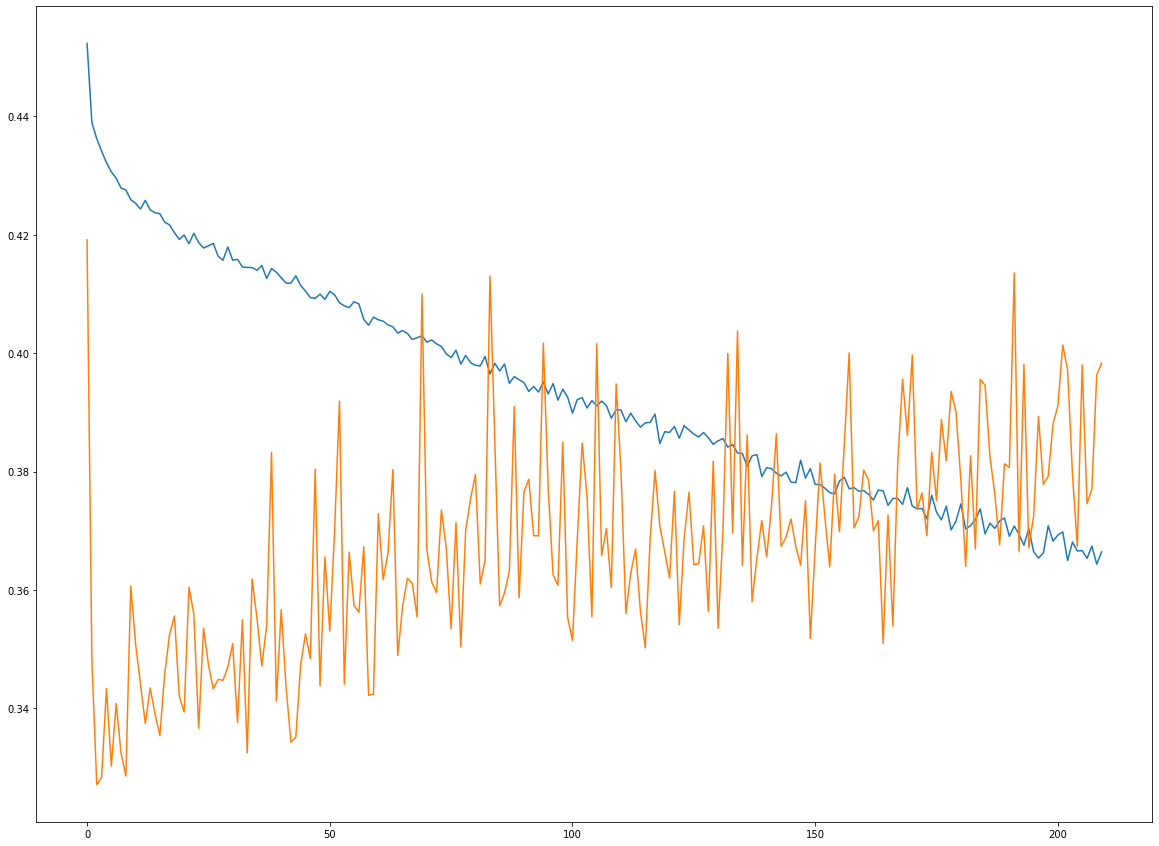

In [ ]:
plt.figure(figsize=(20, 15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

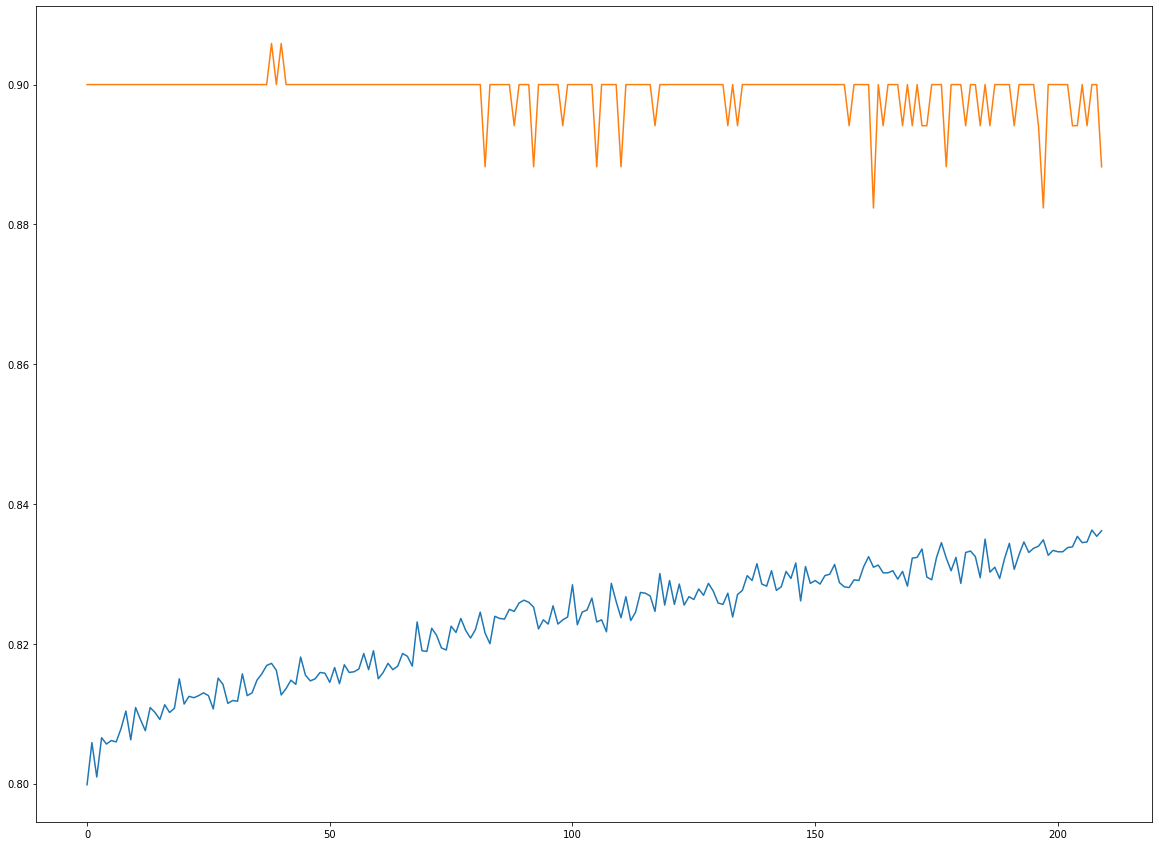

In [ ]:
plt.figure(figsize=(20, 15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
def evaluate_and_fit(X_test, y_test, batch_size):
    predicted = np.array([])
    for i in range(0, X_test.shape[0], batch_size):
        predicted = np.concatenate((predicted, model.predict(X_test[i:i+batch_size]).flatten()), axis=0)
        model.fit(X_test[i:i+batch_size], np.array(y_test[i:i+batch_size]), epochs=20, verbose=0)
    if X_test[i+batch_size:].size > 0:
        predicted = np.concatenate((predicted, model.predict(X_test[i+batch_size:]).flatten()), axis=0)
    return predicted.flatten()

In [ ]:
# dummy model
print(f1_score(y_test_sicily, np.ones(len(y_test_sicily))))

0.9473684210526316


In [ ]:
predicted_sicily = evaluate_and_fit(X_test_sicily, y_test_sicily, 20)

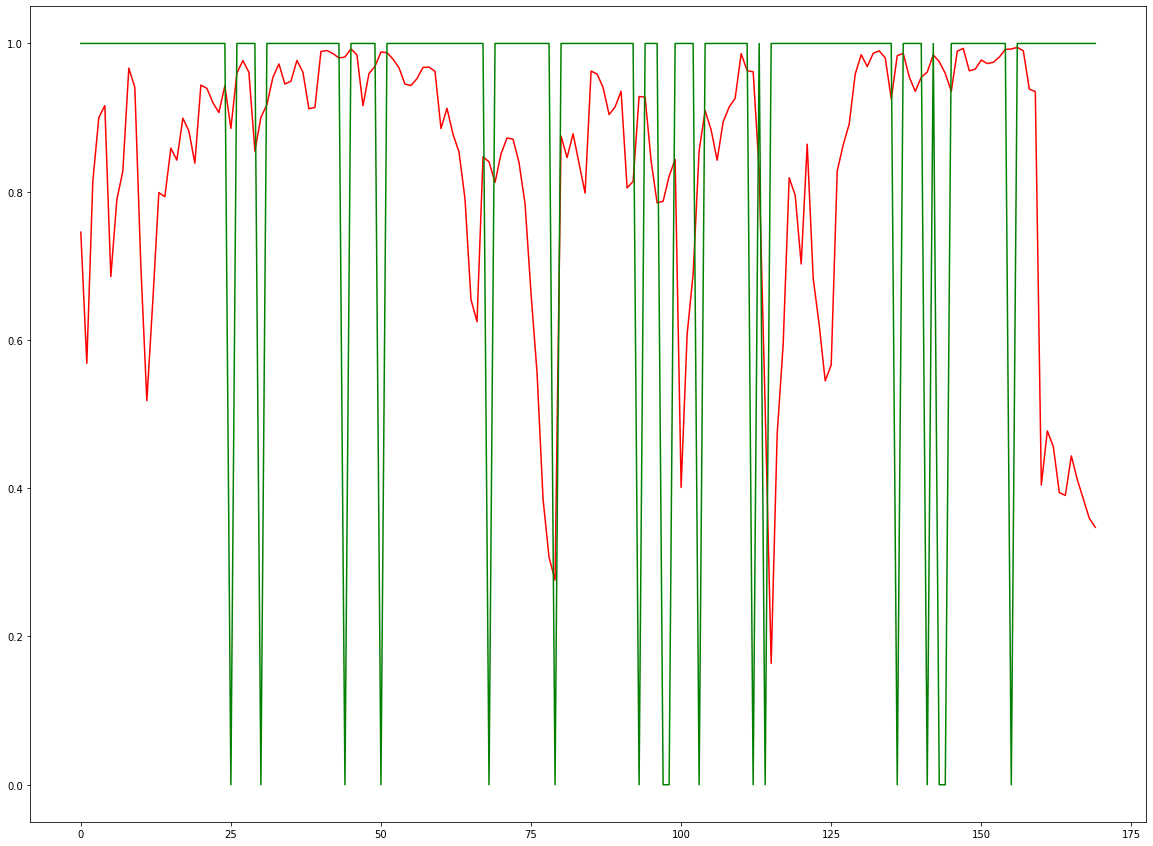

In [ ]:
plt.figure(figsize=(20,15)) 
plt.plot(predicted_sicily, color= 'red')
plt.plot(y_test_sicily, color='green')
plt.show()

In [ ]:
pred = (np.array(predicted_sicily).flatten() > 0.8).astype(int)
f1_score(y_test_sicily, pred)

0.8028673835125447

In [ ]:
# dummy model
print(f1_score(y_test_chile, np.ones(len(y_test_chile))))

0.7909604519774012


In [ ]:
predicted_chile = evaluate_and_fit(X_test_chile, y_test_chile, 20)

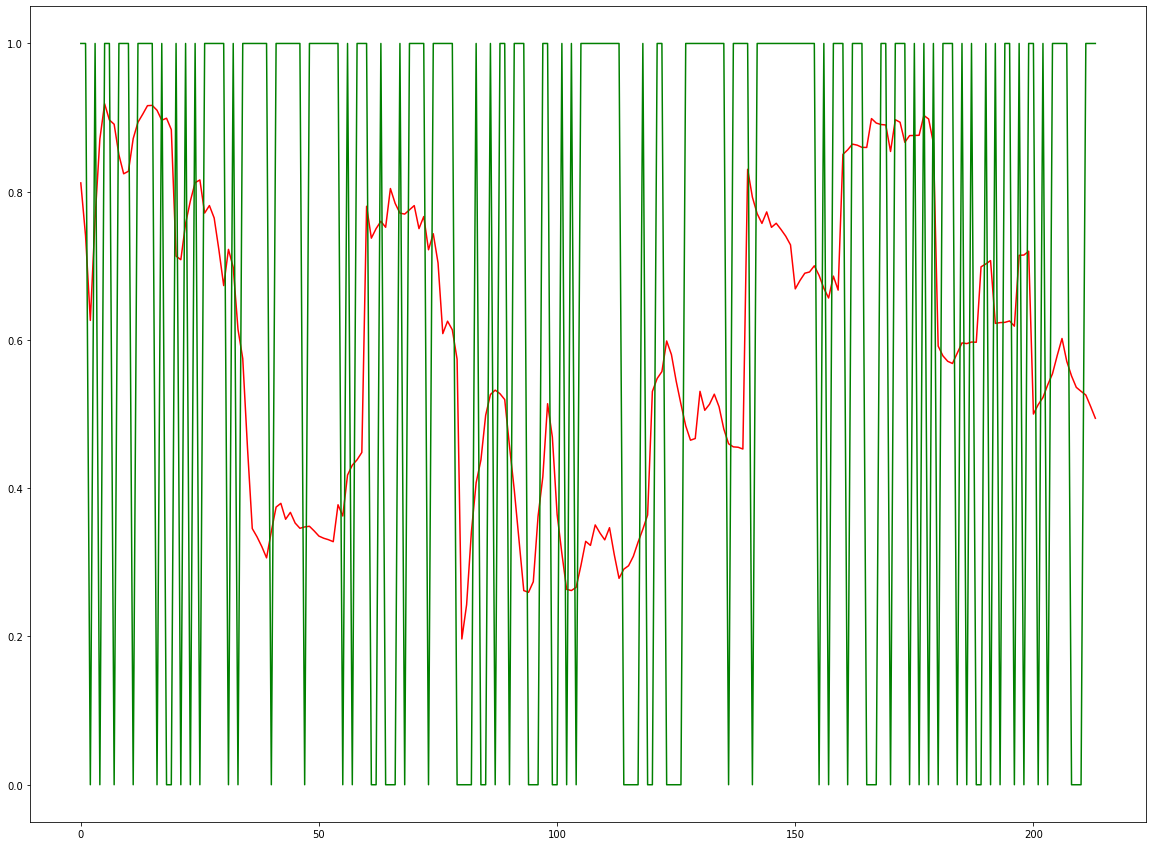

In [ ]:
plt.figure(figsize=(20,15)) 
plt.plot(predicted_chile, color= 'red')
plt.plot(y_test_chile, color='green')
plt.show()

In [ ]:
pred = (np.array(predicted_chile).flatten() > 0.4).astype(int)
f1_score(y_test_chile, pred)

0.7081967213114753

In [ ]:
# dummy model
print(f1_score(y_test_japan, np.ones(len(y_test_japan))))

0.8337595907928389


In [ ]:
predicted_japan = evaluate_and_fit(X_test_japan, y_test_japan, 20)

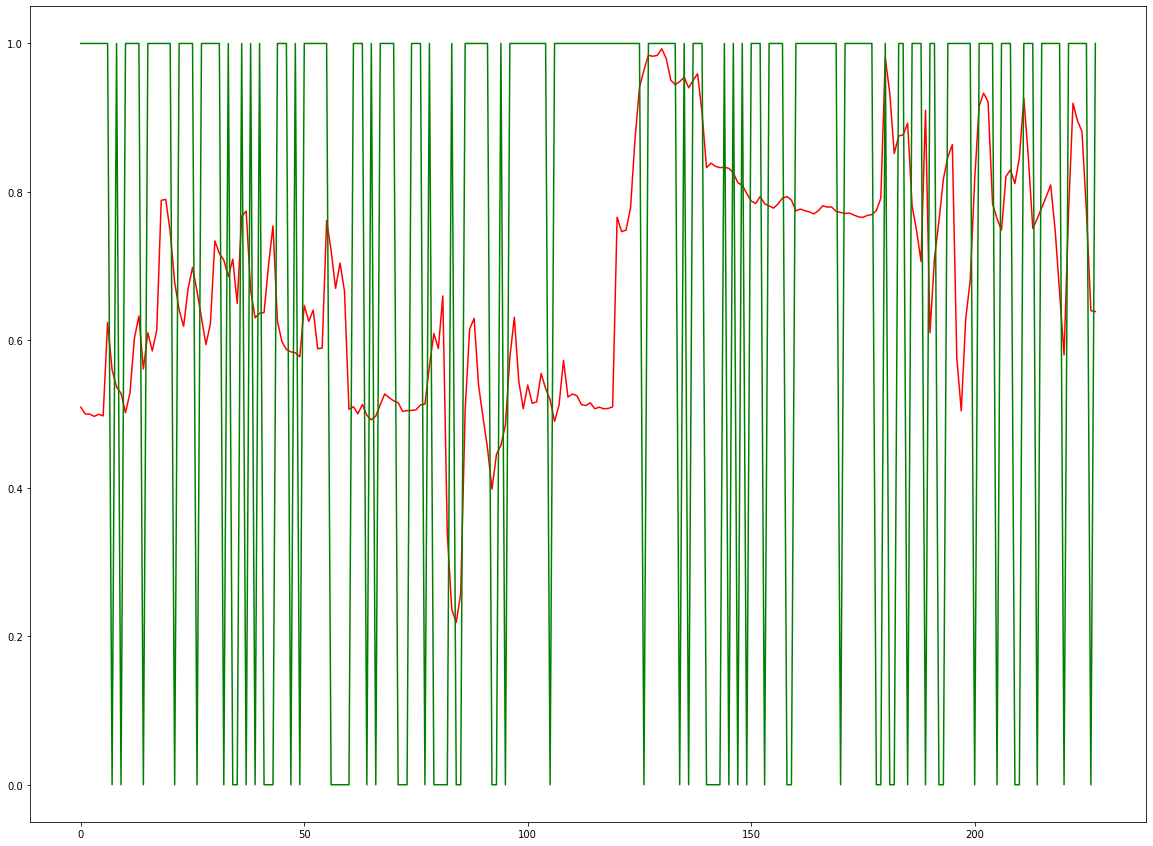

In [ ]:
plt.figure(figsize=(20,15)) 
plt.plot(predicted_japan, color= 'red')
plt.plot(y_test_japan, color='green')
plt.show()

In [ ]:
pred = (np.array(predicted_japan).flatten() > 0.5).astype(int)
f1_score(y_test_japan, pred)

0.8235294117647058

In [ ]:
# dummy model
print(f1_score(y_test_hindukush, np.ones(len(y_test_hindukush))))

0.9845474613686533


In [ ]:
predicted_hindukush = evaluate_and_fit(X_test_hindukush, y_test_hindukush, 20)

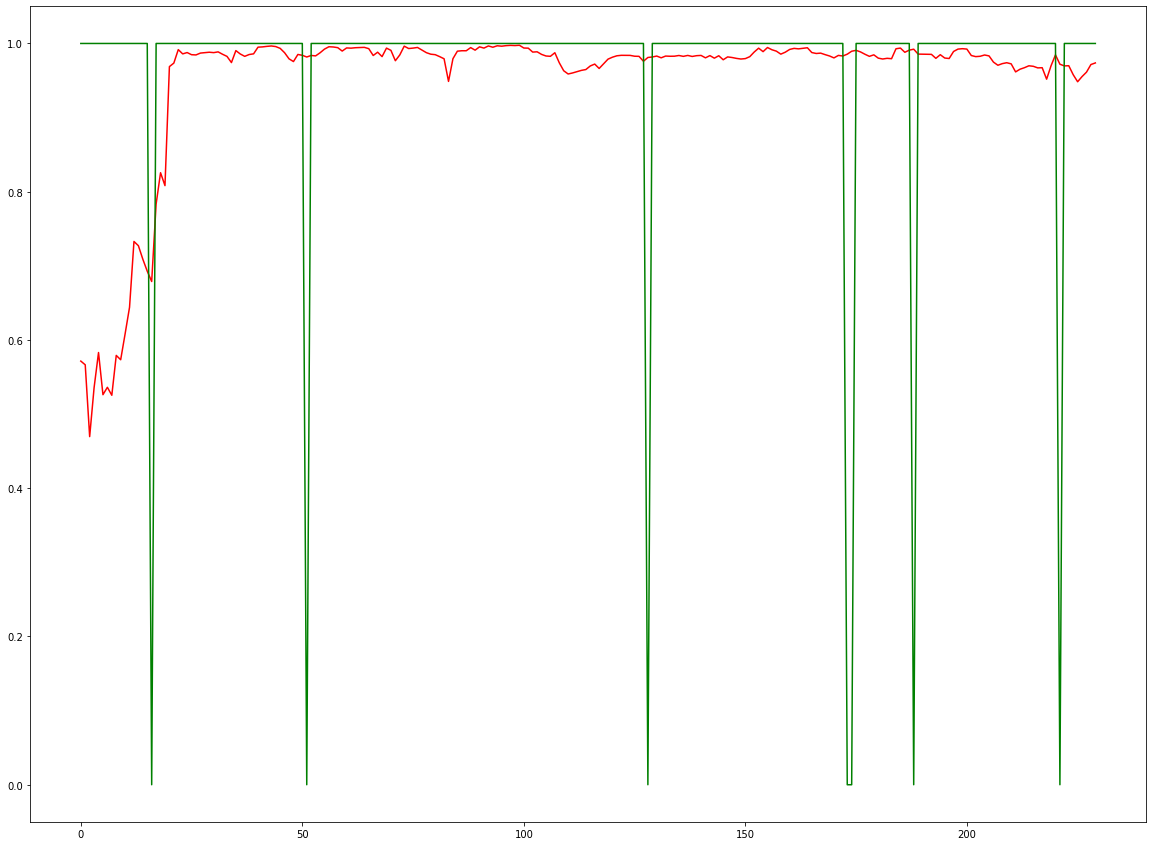

In [ ]:
plt.figure(figsize=(20,15)) 
plt.plot(predicted_hindukush, color= 'red')
plt.plot(y_test_hindukush, color='green')
plt.show()

In [ ]:
pred = (np.array(predicted_hindukush).flatten() > 0.1).astype(int)
f1_score(y_test_hindukush, pred)

0.9845474613686533

In [ ]:
# dummy model
print(f1_score(y_test_california, np.ones(len(y_test_california))))

0.8851063829787233


In [ ]:
predicted_california = evaluate_and_fit(X_test_california, y_test_california, 20)

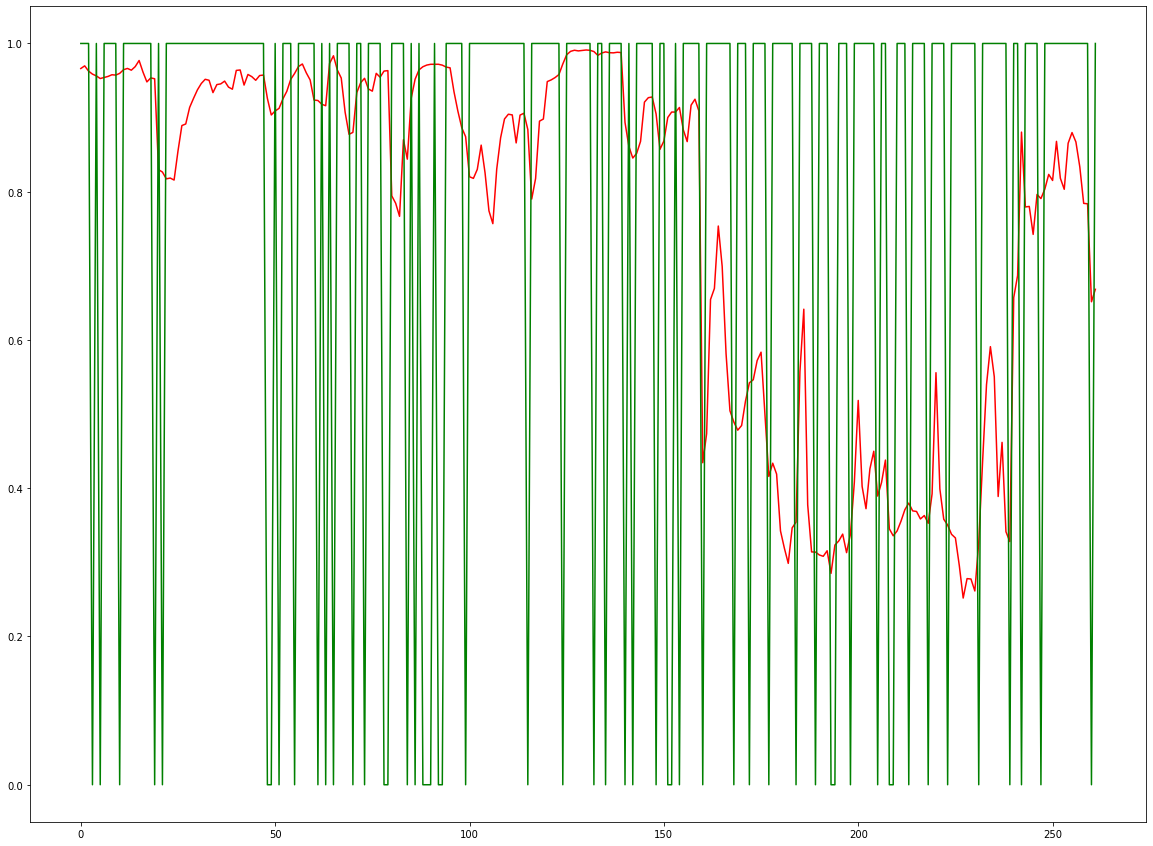

In [ ]:
plt.figure(figsize=(20,15)) 
plt.plot(predicted_california, color= 'red')
plt.plot(y_test_california, color='green')
plt.show()

In [ ]:
pred = (np.array(predicted_california).flatten() > 0.3).astype(int)
f1_score(y_test_california, pred)

0.8725701943844492